#### Epistemic status :
- putain qu'est ce que ce dataset est rincé
- j'espere qu'il y aura des résultats plus stylés dans les autres analysis

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# custom functions (mainly plot helpers)
from helpers import *

# Analysis:
### Did climate change become a topic more important on YouTube as it has become in our society?
Main questions:
- Evolution of the views & number of videos about climate change (and proportion)
- Look also at these only in relevant categories (News, politics, education, etc)
- Channel wise: are many channels taking over this topic?

## 0. Load and prepare the data

In [2]:
data_path = 'data/'
climate_videos_df = pd.read_json(data_path+'refine_filtered_videos.jsonl', lines=True)
nb_videos_df = pd.read_json(data_path+'nb_videos_by_date.jsonl', lines=True)
nb_videos_cat_df = pd.read_json(data_path+'nb_videos_by_date_cat.jsonl', lines=True)
nb_videos_views_df = pd.read_json(data_path+'nb_videos_and_views_by_date.jsonl', lines=True)

For all dataframes, we do :
- rename the columns with useful names (consistent througout all dataframes)
- sort by chronological order
- get the same date format (dayly)
- set the date as index

In [3]:
climate_videos_df.drop('crawl_date', axis=1, inplace=True)
climate_videos_df.rename(columns={'upload_date': 'date', 'view_count': 'nb_views', 'categories': 'category'}, inplace=True)

# sort by date and set date as index
climate_videos_df.sort_values('date', inplace=True)
climate_videos_df.set_index('date', inplace=True)

# day by day
climate_videos_df.index = pd.to_datetime(climate_videos_df.index).floor('D')

In [4]:
nb_videos_df.rename(columns={0: 'date', 1: 'nb_videos'}, inplace=True)

# sort by date and set date as index
nb_videos_df.sort_values('date', inplace=True)
nb_videos_df.set_index('date', inplace=True)

nb_videos_df.index = pd.to_datetime(nb_videos_df.index).floor('D')

In [5]:
nb_videos_cat_df[['category', 'date']] = nb_videos_cat_df[0].apply(pd.Series)
nb_videos_cat_df.drop(0, axis=1, inplace=True)

# sort by date and set date as index
nb_videos_cat_df.sort_values('date', inplace=True)
nb_videos_cat_df.set_index('date', inplace=True)
nb_videos_cat_df.rename(columns={1: 'nb_videos'}, inplace=True)

# day by day
nb_videos_cat_df.index = pd.to_datetime(nb_videos_cat_df.index).floor('D')

In [6]:
nb_videos_views_df.rename(columns={0: 'date', 1: 'nb_videos', 2: 'nb_views'}, inplace=True)

# sort by date and set date as index
nb_videos_views_df.sort_values('date', inplace=True)
nb_videos_views_df.set_index('date', inplace=True)

# day by day
nb_videos_views_df.index = pd.to_datetime(nb_videos_views_df.index).floor('D')

## 1. Evolution of the views & number of videos about climate change

### A. Number of videos and proportion

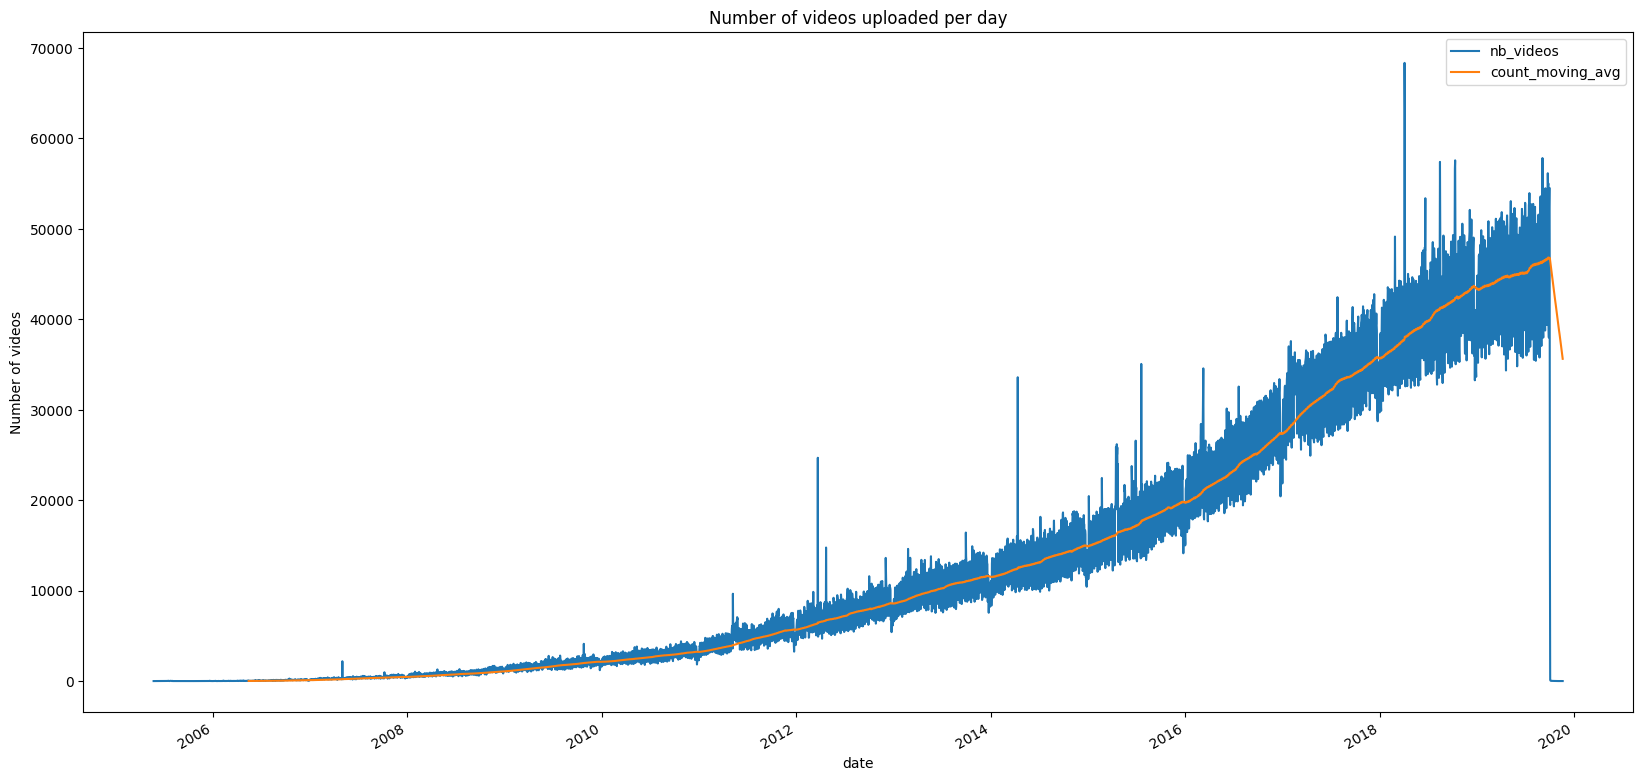

In [7]:
nb_videos_df['nb_videos_cc'] = pd.Series(climate_videos_df.index.value_counts())
nb_videos_df['nb_videos_cc'].fillna(0, inplace=True)
nb_videos_df['count_moving_avg'] = nb_videos_df['nb_videos'].rolling(window=200).mean()

nb_videos_df[['nb_videos', 'count_moving_avg']].plot(figsize=(20, 10))
plt.title('Number of videos uploaded per day')
plt.ylabel('Number of videos')
plt.show()

Based on this graph, we:
- keep the data 1 month before the crawl date 2019-09-29 because the data is less relevant and incomplete after this date.
- start from 2010 because the number of videos is very low before this date and would not be representative.

In [8]:
nb_videos_df = restrict_time_period(nb_videos_df)
climate_videos_df = restrict_time_period(climate_videos_df)
nb_videos_cat_df = restrict_time_period(nb_videos_cat_df)
nb_videos_views_df = restrict_time_period(nb_videos_views_df)


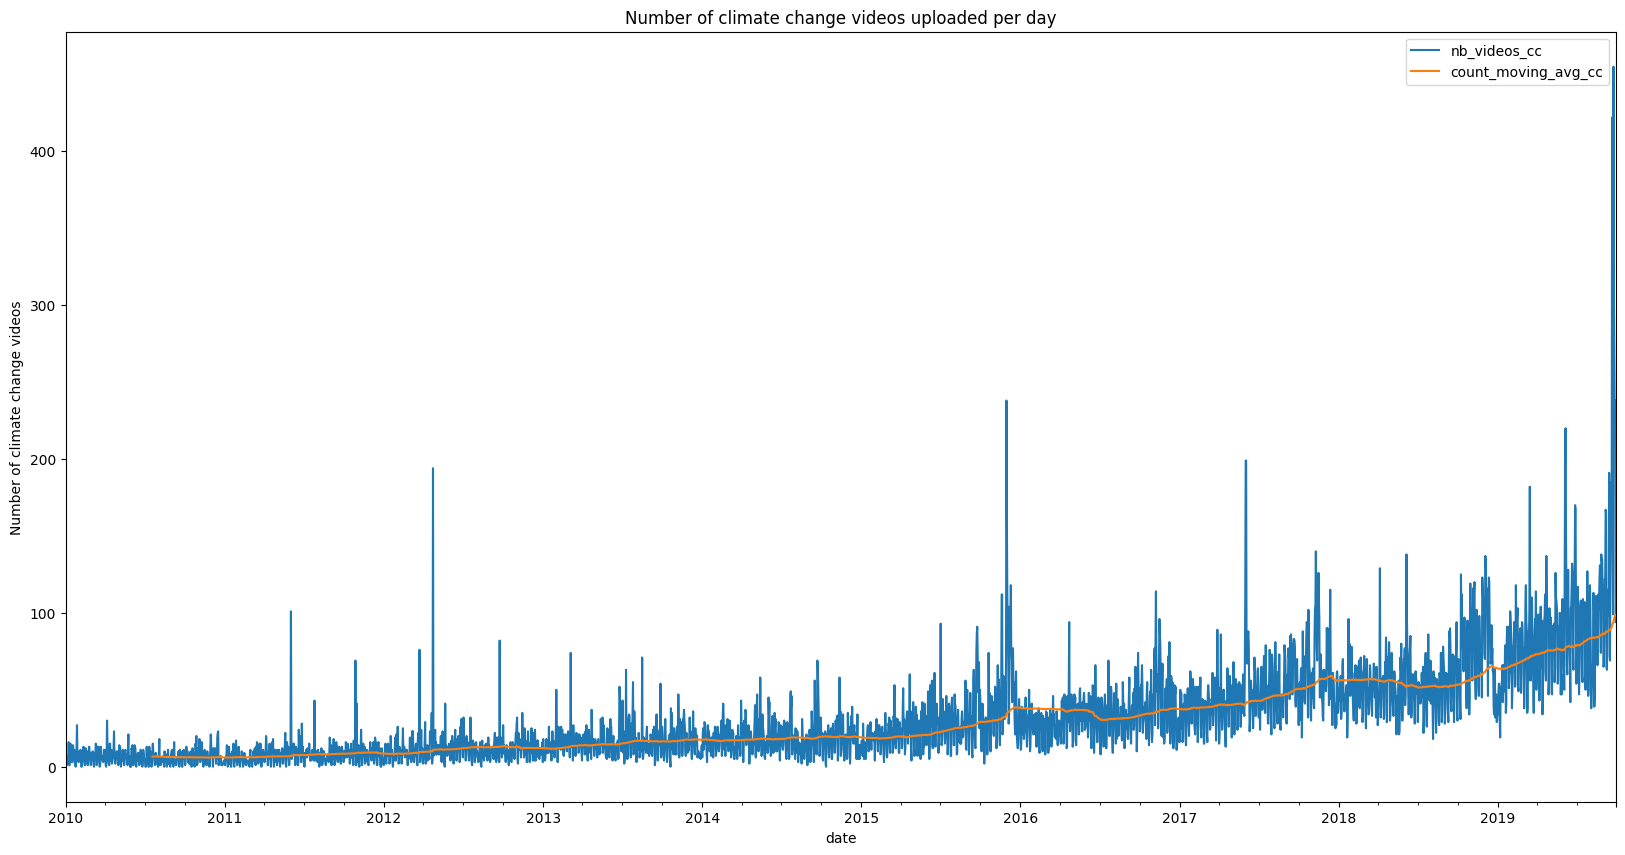

In [9]:
nb_videos_df['count_moving_avg_cc'] = nb_videos_df['nb_videos_cc'].rolling(window=200).mean()

nb_videos_df[['nb_videos_cc', 'count_moving_avg_cc']].plot(figsize=(20, 10))
plt.title('Number of climate change videos uploaded per day')
plt.ylabel('Number of climate change videos')
plt.show()

If we just look at the number of climate change videos being published every day, we see that the trend is increasing over time. However, the total number of videos is also increasing over time, so we have to look at the ratio to see how significant the first trend is.

Now we will look at the evolution of the **proportion** of youtube videos related to climate change. Since there is high variance, we will look at this with different granularities (dayly, weekly, monthly):

In [10]:
# compute percentages
percentage_day = 100* nb_videos_df['nb_videos_cc'] / nb_videos_df['nb_videos']
percentage_week = 100* nb_videos_df['nb_videos_cc'].resample('W').sum() / nb_videos_df['nb_videos'].resample('W').sum()
percentage_month = 100* nb_videos_df['nb_videos_cc'].resample('M').sum() / nb_videos_df['nb_videos'].resample('M').sum()

percentages = [percentage_day, percentage_week, percentage_month]

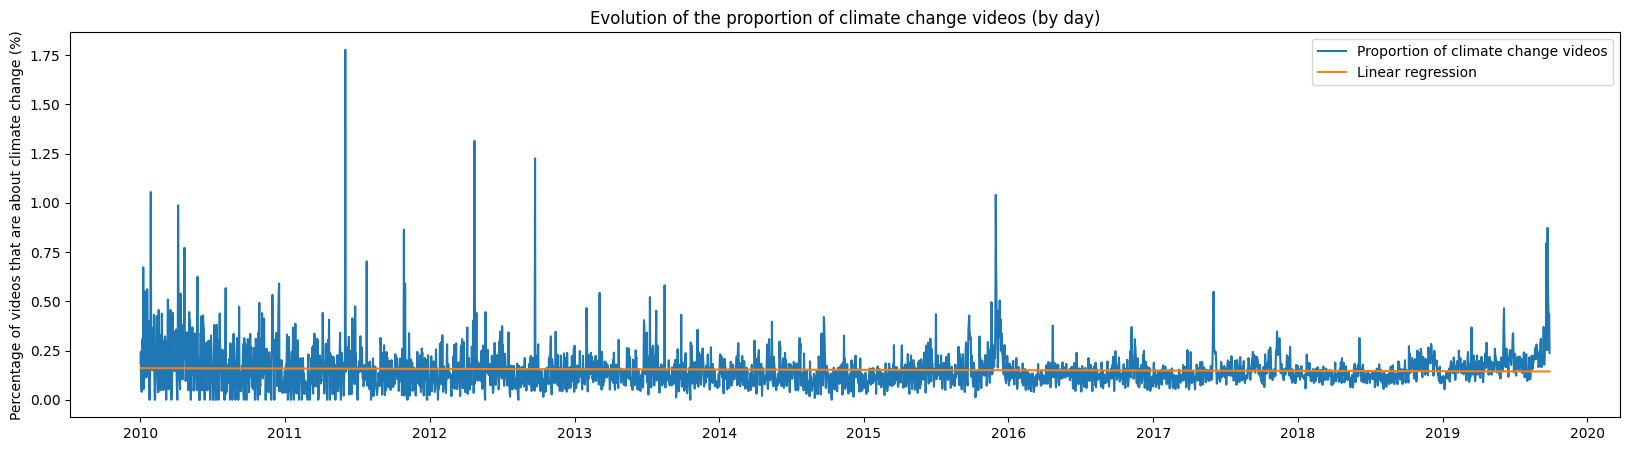

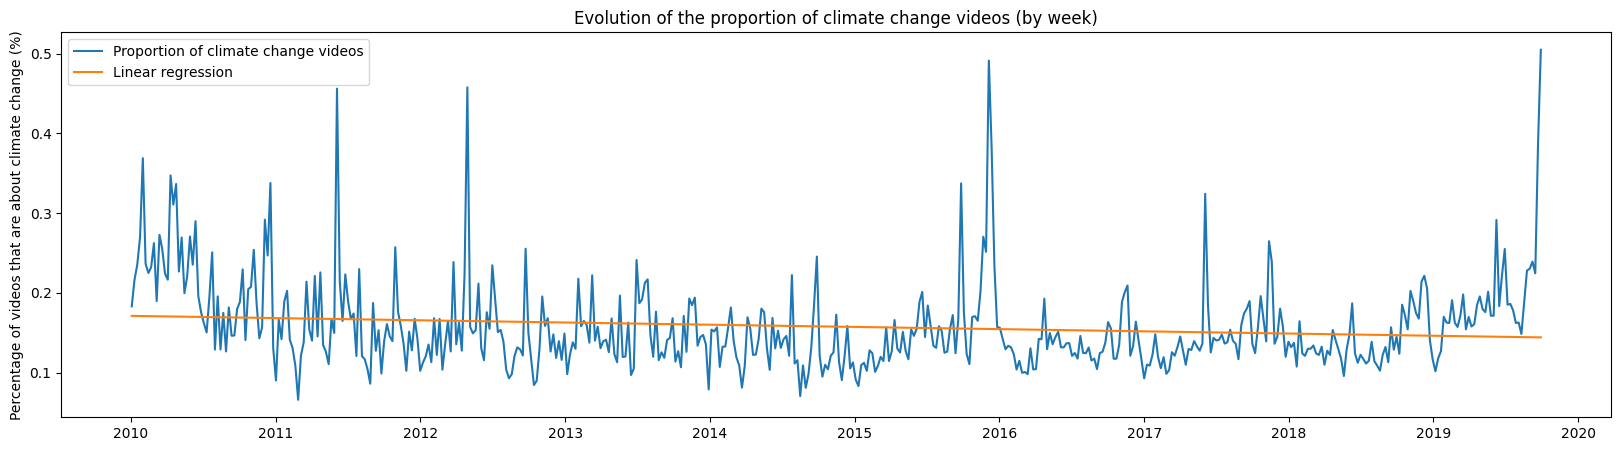

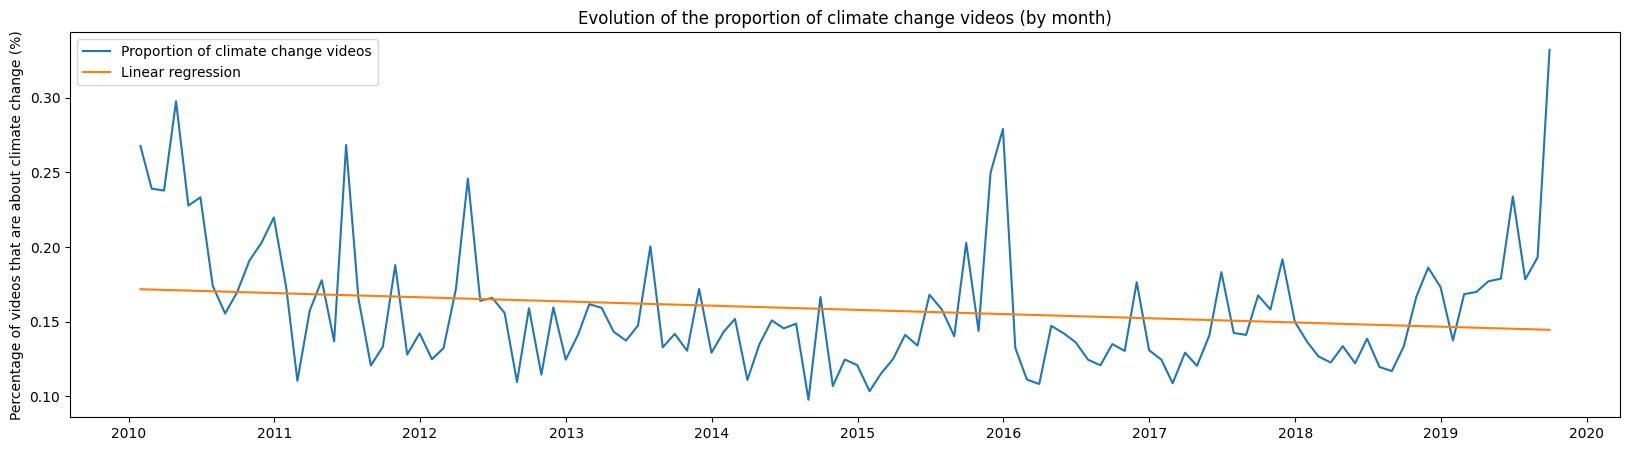

In [11]:
# plot percentages
sample_rate = ['day', 'week', 'month']

for i in range(3):
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    ax.plot(percentages[i].index, percentages[i].values, label='Proportion of climate change videos')
    ax.plot(percentages[i].index, get_linear_fit(percentages[i]), label='Linear regression')
    ax.set_title(f'Evolution of the proportion of climate change videos (by {sample_rate[i]})')
    ax.set_ylabel('Percentage of videos that are about climate change (%)')
    plt.legend()
    plt.show()

We see that the proportion slightly decreases over time. Since we saw that more and more climate change videos were being published every day, this means that the number of CC videos is increasing at a slightly slower rate than the total number of videos on youtube.

### B. Number of views

Let's look at the (average) number of views of climate change videos vs of all videos across time:

In [12]:
#number of CC videos
nb_videos_views_df['nb_videos_cc'] = nb_videos_df['nb_videos_cc']

# number of views of CC videos
nb_videos_views_df['nb_views_cc'] = pd.Series(climate_videos_df.groupby(climate_videos_df.index).nb_views.sum())
nb_videos_views_df.head()

,nb_videos,nb_views,nb_videos_cc,nb_views_cc
date,,,,
2010-01-01,1609,304339199,3.0,149004.0
2010-01-02,1643,116504933,4.0,226385.0
2010-01-03,1663,134688967,2.0,7302.0
2010-01-04,2475,306642485,1.0,118.0
2010-01-05,2288,204714601,7.0,92078.0


In [13]:
# monthly averages
avg_month_tot = nb_videos_views_df['nb_views'].resample('M').sum() / nb_videos_views_df['nb_videos'].resample('M').sum()
avg_month_cc = nb_videos_views_df['nb_views_cc'].resample('M').sum() / nb_videos_views_df['nb_videos_cc'].resample('M').sum()


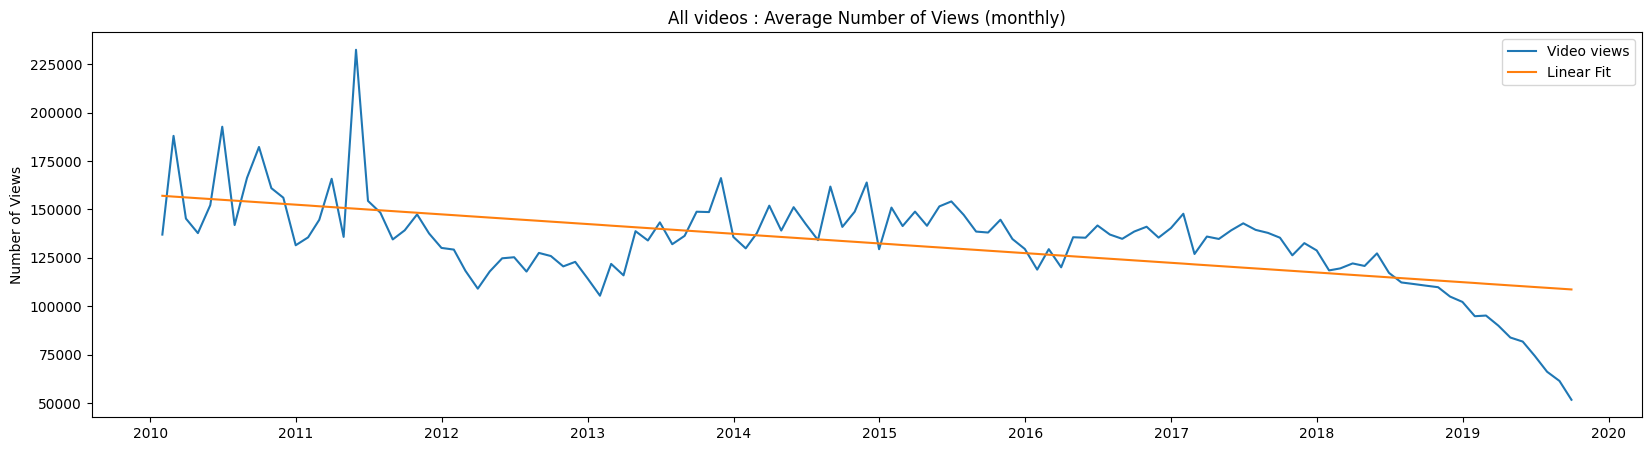

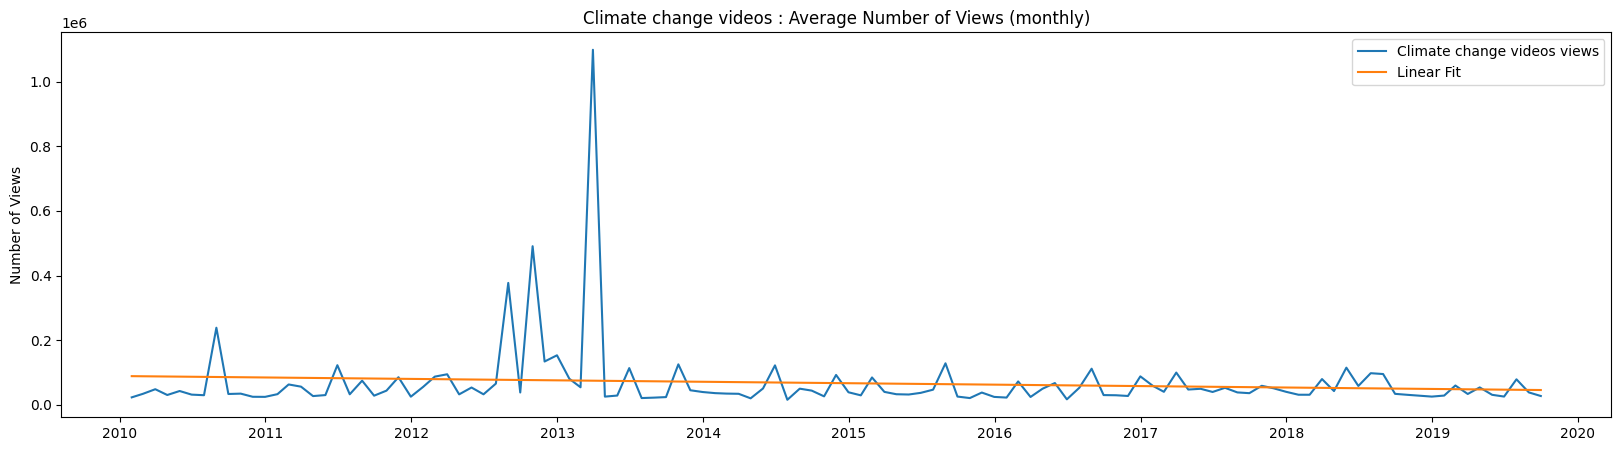

In [14]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(avg_month_tot.index, avg_month_tot.values, label='Video views')
ax.plot(avg_month_tot.index, get_linear_fit(avg_month_tot), label='Linear Fit')
ax.set_title('All videos : Average Number of Views (monthly)')
ax.set_ylabel('Number of Views')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(avg_month_cc.index, avg_month_cc.values, label='Climate change videos views')
ax.plot(avg_month_cc.index, get_linear_fit(avg_month_cc), label='Linear Fit')
ax.set_title('Climate change videos : Average Number of Views (monthly)')
ax.set_ylabel('Number of Views')
plt.legend()
plt.show()

We see that :
- for all videos, the earlier ones tend to cumulate more views in total (have been around for a longer time)
- however, for climate change videos, this is much more steady: people seem to watch less the old videos about climate change (becomes quickly outdated?)

Note that we will try to interpret the spikes later in the analysis (did something particular happen in early 2013??)

## 2. Focusing on key categories
Now, let's focus on just some key categories :
- `Education`
- `News & Politics`
- `Nonprofits & Activism`
- `Science & Technology`

In [15]:
key_categories = ['Science & Technology', 'Education', 'News & Politics', 'Nonprofits & Activism']

print('All categories:')
print(nb_videos_cat_df['category'].unique())

print('\nKey categories:')
print(key_categories)

All categories:
['Pets & Animals' 'Gaming' 'Howto & Style' 'Education' 'Film & Animation'
 'Autos & Vehicles' 'Sports' 'Science & Technology' 'Comedy'
 'Entertainment' 'Travel & Events' 'People & Blogs' 'Music'
 'News & Politics' 'Nonprofits & Activism' '' 'Shows' 'Movies']

Key categories:
['Science & Technology', 'Education', 'News & Politics', 'Nonprofits & Activism']


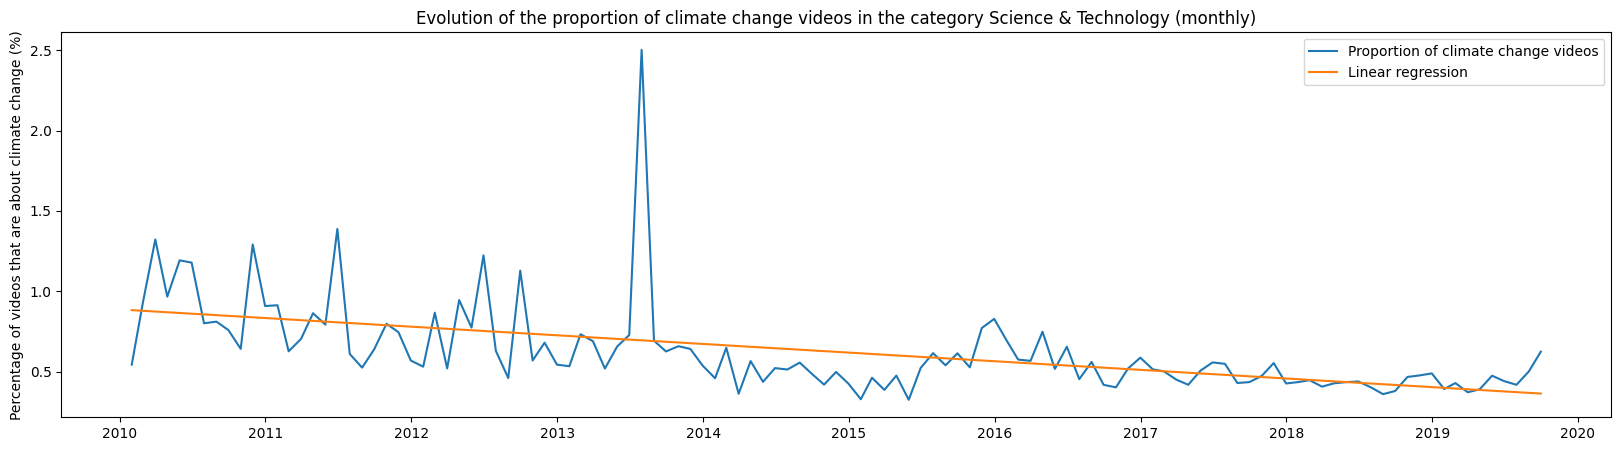

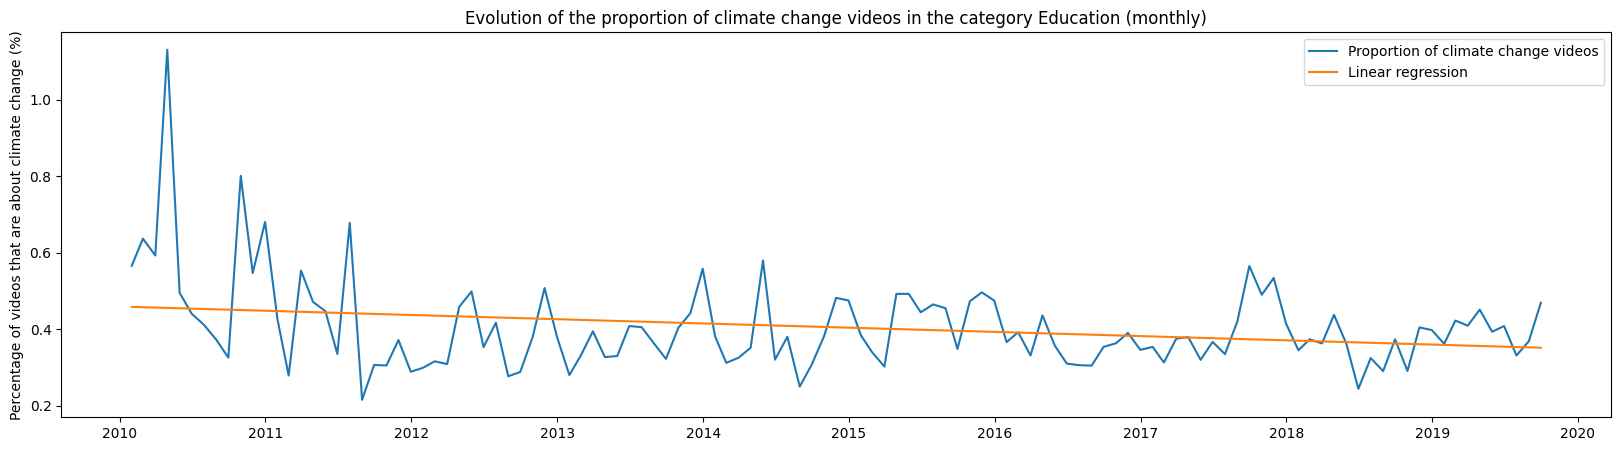

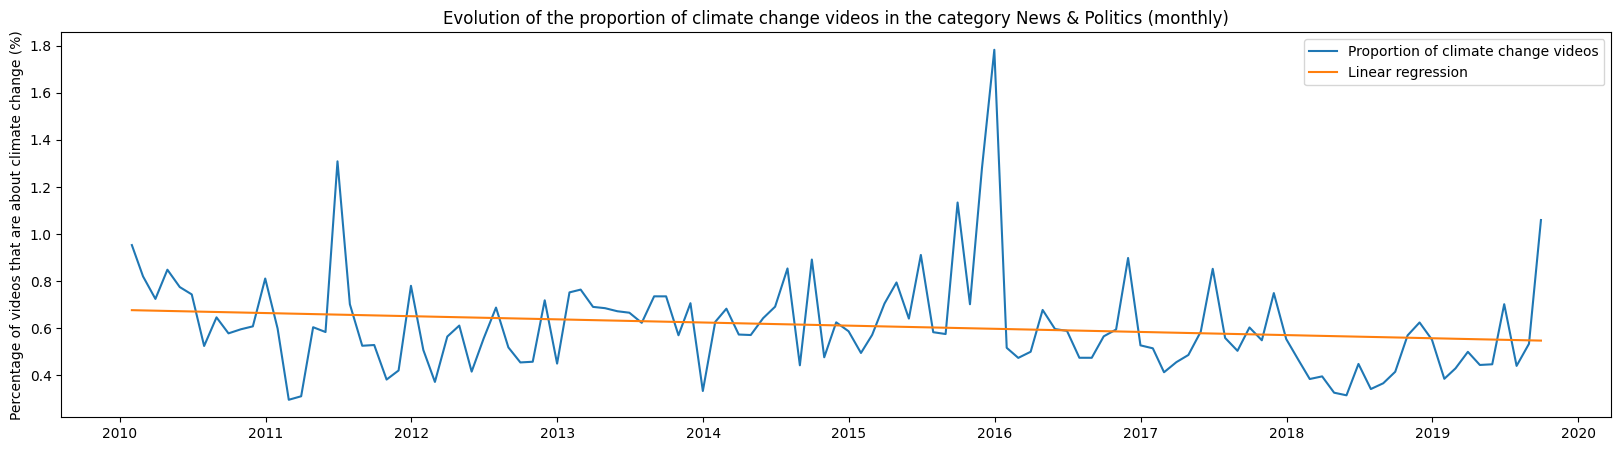

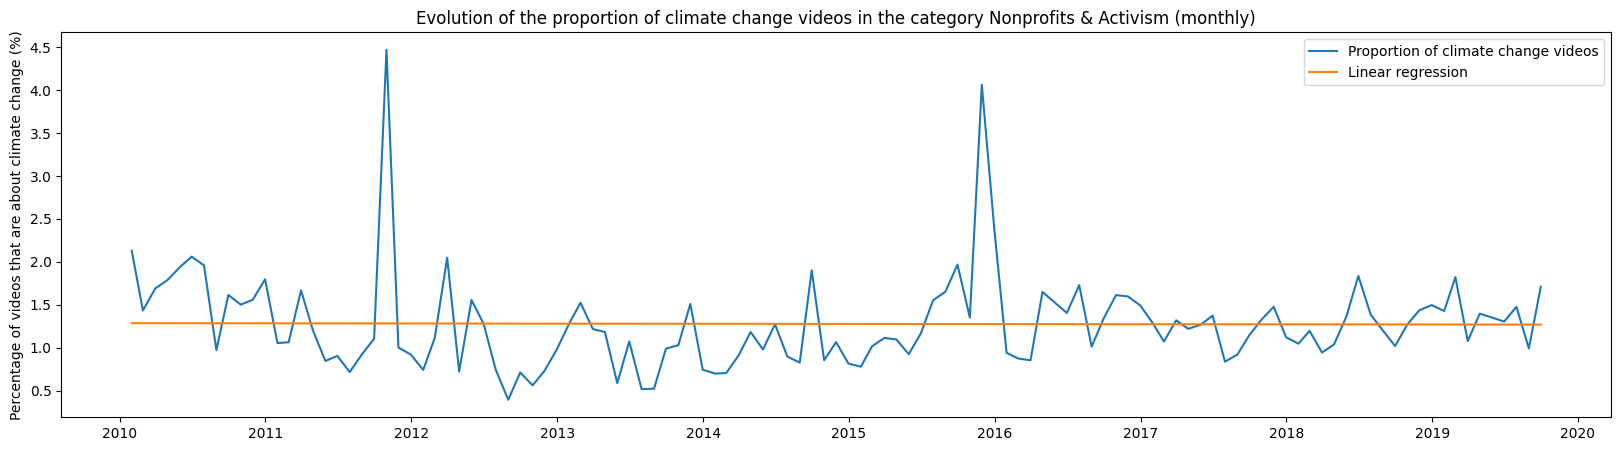

In [16]:
for category in key_categories:
    plot_evolution(category, nb_videos_cat_df, climate_videos_df)

Some interesting spikes (not the same in every category): to be interpreted

## 3. Channel-wise analysis

How are the channels taking over this topic?

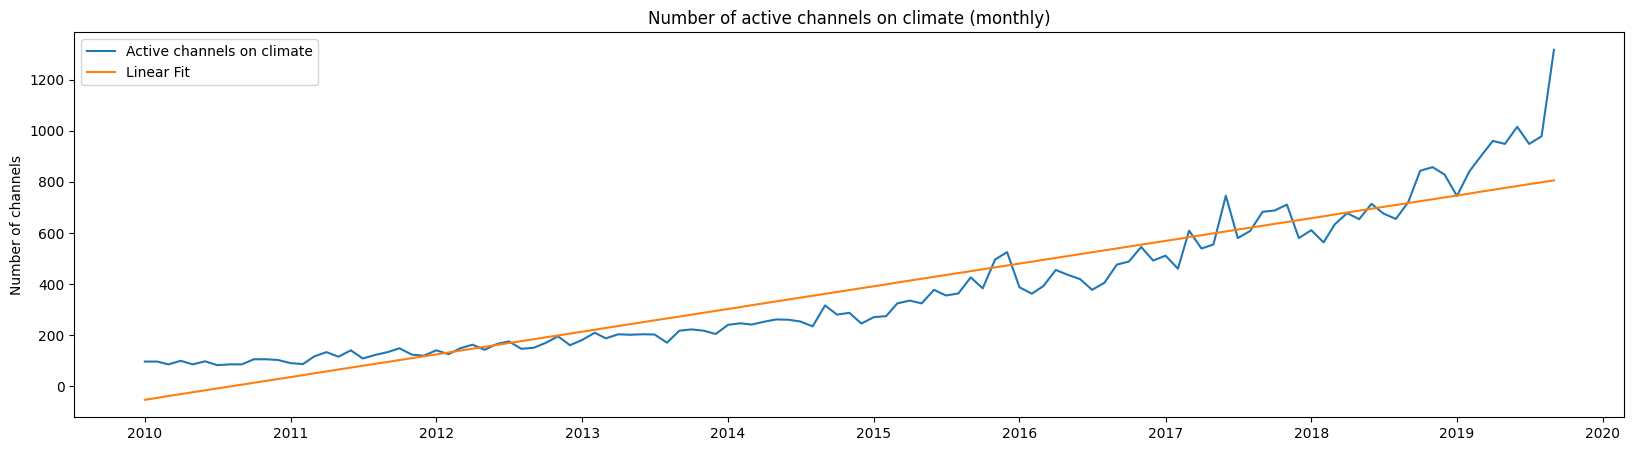

In [36]:
monthly_channel_counts = climate_videos_df.groupby(climate_videos_df.index.to_period('M'))['channel_id'].nunique()
monthly_channel_counts.index = monthly_channel_counts.index.to_timestamp()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(monthly_channel_counts.index, monthly_channel_counts.values, label='Active channels on climate')
ax.plot(monthly_channel_counts.index, get_linear_fit(monthly_channel_counts), label='Linear Fit')
ax.set_title('Number of active channels on climate (monthly)')
ax.set_ylabel('Number of channels')
plt.legend()
plt.show()


(!) Dommage qu'on ne sache pas combien il y avait de channels chaque année